<a href="https://colab.research.google.com/github/aryankotru/MINERVA/blob/main/MINERVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pywt
import math
import csv
import os
from collections import Counter
from scipy.stats import entropy, kurtosis, skew
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import butter, sosfilt,filtfilt,  sosfreqz, lfilter, iirnotch, spectrogram
from google.colab import drive

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
#TODO:
#test with GUI in real-time
#pca - after dimensionality reduction use data as feature extraction
#lda
#ica
#delete data from openbci file after reading
#ignore the first 2 epochs when file starting and ending
#use mne to remove eyeblink artifacts and use headset data
#less features, more bands

In [2]:
if not drive.mount('/content/drive'):
  drive_mounted = True

Mounted at /content/drive


global variable declaration

In [23]:
epoch = 710 #calc epoch len from fs and epoch time len
num_epochs = 12
# Sample rate and desired cutoff frequencies (in Hz)*
fs = 250
lowcut = 5
highcut = 30
filter_order = 3
notch_quality_factor = 10
wavelet = 'sym9'
drive_mounted = False

freq_bands = {"delta": [0.3, 4], "theta": [4, 8], "alpha": [8, 13], "beta": [13, 30], "gamma": [30, 50]}
chars = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "*", "#"]
targets = [1 , 2 ,3 , 4, 5, 6,7,8,9,10,11,12]
feature_names = ['Mean', 'Standard Deviation', 'Skewness', 'Entropy', 'Energy', 'Kurtosis', 'Median' ,'Variance']

tsinghua_channel_names = ['POz', 'PO3', 'PO4', 'PO5', 'PO6', 'Oz', 'O1', 'O2']
channel_names = ["O1", "PO3", "CP3", "C5", "CP4", "C6", "PO4", "O2"]
final_channels = ["PO3", "PO4", "O1", "O2"]
channel_numbers = [1,2,3,4,5,6,7,8]
ssvep_channels = [1,2,3,4]

T =  2.84
nsamples = T * fs
t = np.arange(0, epoch) / fs


In [4]:
def read_input_file(input_file):
    data = []
    with open(input_file, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('%Sample Rate'):
                key_value = line[1:].strip().split(' = ')
                value = key_value[1]
                fs = int(value.strip().split(' ')[0])

            elif line.startswith('Sample Index'):
                header = line.split(', ')
            else:
                data.append(line.split(', ')) #typecast as int'

    data = [sublist[1:][:8] for sublist in data[3:]]
    converted_array = np.array(data, dtype=float).tolist()

    return fs, header[:9], converted_array

def clear_file(input_file):
  with open(input_file, 'w') as file:
    file.writelines(" ")
  return

def get_latest_subdirs(b):
  result = []
  for d in os.listdir(b):
    bd = os.path.join(b, d)
    if os.path.isdir(bd): result.append(bd)
    latest_subdir = max(result, key=os.path.getmtime)
  return latest_subdir


def get_input_raw_file(latest_subdir):
  file_names = []
  for x in os.listdir(latest_subdir):
    if x.endswith(".txt"):
      filepath = os.path.join(latest_subdir, x)
    else:
      return "No matching file"
  return filepath


In [20]:
#fs, header, data = read_input_file(f"/content/OpenBCI-RAW-2024-06-10_14-01-02.txt")
input_dir = f"/content/drive/MyDrive/Final Year Project/Machine Learning/Datasets/rawcsv"
files = []
for x in os.listdir(input_dir):
    if x.endswith(".csv"):
      files.append(x)
      files.sort()
print(files)
#fs, header, data = read_input_file(input_file)
#print(fs)
"""
#fs, data = convert_and_write_output(output_file,  header, data)
df = pd.DataFrame(data, columns = channel_names)
df = df.iloc[:, :]
df"""

['S001.csv', 'S002.csv', 'S003.csv', 'S004.csv', 'S005.csv', 'S006.csv', 'S007.csv', 'S008.csv', 'S009.csv', 'S010.csv', 'S011.csv', 'S012.csv', 'S013.csv', 'S014.csv', 'S015.csv', 'S016.csv', 'S017.csv', 'S018.csv', 'S019.csv', 'S020.csv', 'S021.csv', 'S022.csv', 'S023.csv', 'S024.csv', 'S025.csv', 'S026.csv', 'S027.csv', 'S028.csv', 'S029.csv', 'S030.csv', 'S031.csv', 'S032.csv', 'S033.csv', 'S034.csv', 'S035.csv', 'S036.csv', 'S037.csv', 'S038.csv', 'S039.csv', 'S040.csv', 'S041.csv', 'S042.csv', 'S043.csv', 'S044.csv', 'S045.csv', 'S046.csv', 'S047.csv', 'S048.csv', 'S049.csv', 'S050.csv', 'S051.csv', 'S052.csv', 'S053.csv', 'S054.csv', 'S055.csv', 'S056.csv', 'S057.csv', 'S058.csv', 'S059.csv', 'S060.csv', 'S061.csv', 'S062.csv', 'S063.csv', 'S064.csv', 'S065.csv', 'S066.csv', 'S067.csv', 'S068.csv', 'S069.csv', 'S070.csv', 'S071.csv', 'S072.csv', 'S073.csv', 'S074.csv', 'S075.csv', 'S076.csv', 'S077.csv', 'S078.csv', 'S079.csv', 'S080.csv', 'S081.csv', 'S082.csv', 'S083.csv', 'S0

'\n#fs, data = convert_and_write_output(output_file,  header, data)\ndf = pd.DataFrame(data, columns = channel_names)\ndf = df.iloc[:, :]\ndf'

In [6]:
def butter_bandstop(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    return b, a
def bandstop_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandstop(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
# Filter the signal
#y = bandstop_filter(x, lowcut, highcut, fs, order=6)
def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop', analog = False)#, fs, )
    y = filtfilt(b, a, data)
    return y

#print("Filtering signal, please wait...")
#signal_filtered = butter_bandstop_filter(y, lowcut, highcut, fs, order)

data filtering

In [7]:
def notch_filter(data, rate, freq, quality):
      x = scipy.signal.filtfilt(*scipy.signal.iirnotch(freq / (rate / 2), quality), data)
      #https://neuraldatascience.io/7-eeg/erp_filtering.html
      return x

def butter_bandpass(lowcut, highcut, fs, order=filter_order):
    return butter(order, [lowcut, highcut], fs=fs, btype='bandpass', analog = False)

def butter_bandpass_filter(data, lowcut, highcut, fs, order = filter_order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y =  filtfilt(b, a, data)
    return y

def butter_bandpass_sos(lowcut, highcut, fs, order=filter_order):
        nyq = 0.5 * fs #
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='bandpass', output='sos')
        return sos

def butter_bandpass_filter_sos(data, lowcut, highcut, fs, order=filter_order):
        sos = butter_bandpass_sos(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [ ]:
epoch_time = 6
fs = fs
epoch_len = epoch_time * fs
print(epoch_len)
#for n in range(8):
""" plt.figure(figsize = (20,5))
plt.grid(True)
plt.xlabel("time (in seconds)")
plt.ylabel("signal amplitude (in μV)")
plt.title("Plot of " + str(n+1)+ "th column")
data = df.iloc[1*750:2*750, n]
t = np.arange(0, len(data)) / fs
plt.figure(figsize = (20,5))
plt.plot(t, data, label = "Unfiltered Signal")
data = notch_filter(data, fs, 50, notch_quality_factor)
#data = notch_filter(data, fs, 60, notch_quality_factor)
plt.figure(figsize = (20,5))
plt.plot(t, data, label = "Notch Filtered Signal")
data = butter_bandpass_filter(data, lowcut, highcut, fs, order= filter_order)
plt.figure(figsize = (20,5))
plt.plot(t, data, label = "Bandpass Filtered Signal" )"""
for i in range(len(df)//epoch_len):

  #for channel in [0,1,6,7]:
  data = df.iloc[i*epoch_len:(i+1)*epoch_len, 0]
  #data = df.iloc[:,0]
  plt.figure(figsize = (20,5))
  plt.grid(True)
  plt.xlabel("time (in seconds)")
  plt.ylabel("signal amplitude (in μV)")
  plt.title("Plot of" + f"Epoch {i}"+ "column")
  t = np.arange(0, len(data)) / fs
  plt.plot(t, data, label = "Unfiltered Signal" + f"Epoch {i}")
  #data = notch_filter(data, fs, 50, notch_quality_factor)
  #data = notch_filter(data, fs, 60, notch_quality_factor)
  #plt.figure(figsize = (20,5))
  #plt.plot(t, data, label = "Notch Filtered Signal")
  data = butter_bandpass_filter(data, 8 , 40, fs, order=6)
  notch_quality_factor = 20
  data = notch_filter(data, fs, 10, notch_quality_factor)

  fft_data = np.abs(np.fft.fft(data))
  fft_data[0]=0
  timestep = 1/fs
  freq = np.abs(np.fft.fftfreq(len(data), d = timestep))

  fig = plt.figure(figsize = (20,5))
  minor_ticks = np.arange(0, len(data), 5)
  ax = fig.add_subplot(1, 1, 1)
  ax.set_xticks(minor_ticks, minor=True)
  ax.set_yticks(minor_ticks, minor=True)
  ax.grid(which='both')
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  plt.title('FFT for ' + f"Epoch {i}" + f" Channel {0}")
  plt.plot(freq, fft_data)
  plt.show()
  notch_quality_factor = 20
  data = notch_filter(data, fs, 50, notch_quality_factor)
  #data = notch_filter(data, fs , 0.01, notch_quality_factor)
  #data = butter_bandpass_filter(data,3, 30, fs, order= 6)
  #data = butter_bandstop_filter(data, 0.01, 5, fs, order = 6)
  #plt.figure(figsize = (20,5))
  #plt.plot(t, data, label = "Bandpass Filtered Signal" + f"Epoch {i}" )

  """fft_data = np.abs(np.fft.fft(data))
  fft_data[0]=0
  timestep = 1/fs
  freq = np.abs(np.fft.fftfreq(len(data) , d = timestep))

  fig = plt.figure(figsize = (20,5))
  minor_ticks = np.arange(0, len(data), 5)
  ax = fig.add_subplot(1, 1, 1)
  ax.set_xticks(minor_ticks, minor=True)
  ax.set_yticks(minor_ticks, minor=True)
  ax.grid(which='both')
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  plt.title('Notched FFT for ' + f"Epoch {i}" + f" Channel {0}")
  plt.plot(freq, fft_data)
  plt.show()
"""
  """fig = plt.figure(figsize = (20,5))
  minor_ticks = np.arange(0, len(data), 5)
  ax = fig.add_subplot(1, 1, 1)
  ax.set_xticks(minor_ticks, minor=True)
  ax.grid(which='both')
  psd_y = plt.psd(fft_data, Fs = fs)"""

data normalization

In [8]:
def dataset_scaler(dataframe, column_names):
  scaler = MinMaxScaler() #normalizing data points, object of class StandardScaler
  minmax_scaled_data = scaler.fit_transform((dataframe))
  np.reshape(minmax_scaled_data, dataframe.shape)
  scaled_data = np.vstack((minmax_scaled_data))
  dfa = pd.DataFrame(minmax_scaled_data)
  dfa.columns = column_names #index for columns
  return dfa

In [9]:
def eta(data, unit='shannon'):
    base = {
        'shannon' : 2.,
        'natural' : math.exp(1),
        'hartley' : 10.}
    if len(data) <= 1:
        return 0
    counts = Counter()
    for d in data:
        d = round(d, 3)
        counts[d] += 1
    ent = 0
    probs = [float(c) / len(data) for c in counts.values()]
    for p in probs:
        if p > 0.:
            ent -= p * math.log(p, base[unit])
    return ent
  #https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python

def calculate_features(coeffs):
    mean_val = np.mean(coeffs)
    std_val = np.std(coeffs) #maybe try variance
    skewness_val = skew(coeffs)
    entropy_val = eta(coeffs)
    energy = np.sum(coeffs**2)
    kurtosis_value = kurtosis(coeffs)
    median_value = np.median(coeffs)
    variance_value = np.var(coeffs)
    return mean_val, std_val, skewness_val, entropy_val, energy, kurtosis_value, median_value, variance_value

wavelet transform & feature extraction

In [10]:
def feature_generator(df, epoch_len):
    num_epochs = int(len(df) / epoch_len)
    all_features = []

    for n in range(num_epochs):
        #for channel in channel_numbers[:4]:
        for channel in ssvep_channels:
            data = df.iloc[n * epoch_len:(n + 1) * epoch_len, channel-1]
            coeffs = pywt.wavedec(data, wavelet, level = 5) #returns level+1 values, level detail coeffs and 1 approx
            """Frequency Bands:
              The frequency range corresponding to each level is calculated. For a sampling frequency of 250 Hz, the levels correspond roughly to:
              Level 1: 62.5 - 125 Hz
              Level 2: 31.25 - 62.5 Hz
              Level 3: 15.625 - 31.25 Hz
              Level 4: 7.8125 - 15.625 Hz
              Level 5: 3.9062 - 7.8125 Hz
              Approximation: 0 - 3.9062 Hz
              The alpha band (8-13 Hz) lies within Level 4."""
            for i, coeff in enumerate(coeffs[2:4], 1):
                features = calculate_features(coeff)
                all_features.append([channel] + list(features))
            #features = calculate_features(coeffs[0])
            #all_features.append([channel] + list(features))

    feature_df = pd.DataFrame(all_features, columns=['Channel'] + feature_names)
    feature_df.set_index('Channel', inplace=True)

    return feature_df


dataset labeller

In [11]:
level_map = [1,2,3,4,5]
feature_map = [1,2,3,4]
chars = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

#num = 20 for label, num = 1 for feature,  num = 4 for level
#n = 0 for label, n = 1 for feature, n = 2 for level, in order

def drop_column(dataframe, column_name):
  try:
    df = dataframe.drop(columns=column_name, axis =1)
    return df
  except Exception as e:
    return dataframe

def dataset_labeller(dataframe, num_features_per_epoch, chars, n, label):
  num_samples = len(dataframe) // num_features_per_epoch
  num_labels = len(chars)  # 12 labels

  # Create a list of labels for each 32-row segment
  labels = []
  for i in range(num_samples):
      labels.extend([chars[i % num_labels]] * num_features_per_epoch)
  # Add the labels to the DataFrame
  dataframe.insert(dataframe.shape[1]-n, label , labels, allow_duplicates = False) #df.shape[1] returns the number of columns
  return dataframe

In [12]:
def preprocessing(dataframe, epoch_len):

   filtered_df = pd.DataFrame(columns=dataframe.columns)
   num_epochs = round(int(len(dataframe.index)/epoch_len))
   #print(num_epochs)

   for channel, i in enumerate(dataframe.columns):
      filtered_col_data = []
      for n in range(num_epochs):
          data = dataframe.iloc[n*epoch:(n+1)*epoch, channel]
          data = notch_filter(data, fs, 50, notch_quality_factor)
          data = butter_bandpass_filter(data, lowcut, highcut, fs, order=filter_order)
          filtered_col_data.extend(data)
      filtered_df[i] = filtered_col_data
   feature_df = feature_generator(filtered_df, epoch_len) #extract and store features
   scaled_df = dataset_scaler(feature_df,  feature_names) #scale dataset AFTER filtering
   return scaled_df

In [13]:
def flatten(dataframe, segment_height, segment_width):
  # Define the segment size
  # Calculate the number of segments
  num_segments = dataframe.shape[0] // segment_height

  # Initialize a list to hold the flattened vectors
  flattened_vectors = []

  for i in range(num_segments):
      # Extract the 8x32 segment
      segment = dataframe.iloc[i * segment_height:(i + 1) * segment_height, :]
      #print(segment)

      # Flatten the segment into a 1D vector of length 256
      flattened_vector = segment.to_numpy().flatten()

      # Add the flattened vector to the list
      flattened_vectors.append(flattened_vector)

  # Convert the list of vectors to a NumPy array
  flattened_vectors = np.array(flattened_vectors)

  #print("Original data shape:", dataframe.shape)
  #print("Flattened data shape:", flattened_vectors.shape)
  da =  pd.DataFrame(flattened_vectors)
  return da


# **main function**

In [24]:
def main(input_method, input_file):
  if input_method == 'system_read':
    #epoch_len = fs * 3
    #dir = get_latest_subdirs('/content')
    #input_file = get_input_raw_file("/content/OpenBCI-RAW-2024-06-10_14-01-02.txt")  # Replace with your input file path
    fs, header, data = read_input_file(f"/content/OpenBCI-RAW-2024-06-10_14-01-02.txt")
    #fs, data = convert_and_write_output(output_file,  header, data)
    df = pd.DataFrame(data, columns = channel_names)

  elif input_method == 'manual_read':
    fs = 250
    epoch_len = 710
    #Load EEG data from the csv file
    df = pd.read_csv(input_file, header = None)
    #df = pd.read_csv(f"/content/drive/MyDrive/Final Year Project/Machine Learning/ML Models/Datasets/MINERVA_dataset/S001.csv", header = None)
    df = np.transpose(df)
    df.columns = tsinghua_channel_names
    #print(df.columns)
    num_rows, num_cols = df.shape
    num_epochs = int((num_rows)/epoch)

  df = preprocessing(df, 710)
  dataset = flatten(df, segment_height = 8, segment_width = 8)
  labelled_dataset = dataset_labeller(dataset, 1, targets, 0, 'Label')
  #output = labelled_dataset.to_excel(f'MINlambda.xlsx', sheet_name='sheet1',  float_format = "%.8f")
  return labelled_dataset

if __name__ == '__main__':
  """df_final = pd.DataFrame()
  input_dir = f"/content/drive/MyDrive/Final Year Project/Machine Learning/Datasets/rawcsv"
  files = []
  for x in os.listdir(input_dir):
      if x.endswith(".csv"):
        files.append(x)
        files.sort()
  print(files)
  for file in files:
    #df = main('manual_read', f"/content/drive/MyDrive/Final Year Project/Machine Learning/Datasets/rawcsv/{file}")
    df_final = pd.concat([df_final, df], axis = 0)
    df_final"""


['S001.csv', 'S002.csv', 'S003.csv', 'S004.csv', 'S005.csv', 'S006.csv', 'S007.csv', 'S008.csv', 'S009.csv', 'S010.csv', 'S011.csv', 'S012.csv', 'S013.csv', 'S014.csv', 'S015.csv', 'S016.csv', 'S017.csv', 'S018.csv', 'S019.csv', 'S020.csv', 'S021.csv', 'S022.csv', 'S023.csv', 'S024.csv', 'S025.csv', 'S026.csv', 'S027.csv', 'S028.csv', 'S029.csv', 'S030.csv', 'S031.csv', 'S032.csv', 'S033.csv', 'S034.csv', 'S035.csv', 'S036.csv', 'S037.csv', 'S038.csv', 'S039.csv', 'S040.csv', 'S041.csv', 'S042.csv', 'S043.csv', 'S044.csv', 'S045.csv', 'S046.csv', 'S047.csv', 'S048.csv', 'S049.csv', 'S050.csv', 'S051.csv', 'S052.csv', 'S053.csv', 'S054.csv', 'S055.csv', 'S056.csv', 'S057.csv', 'S058.csv', 'S059.csv', 'S060.csv', 'S061.csv', 'S062.csv', 'S063.csv', 'S064.csv', 'S065.csv', 'S066.csv', 'S067.csv', 'S068.csv', 'S069.csv', 'S070.csv', 'S071.csv', 'S072.csv', 'S073.csv', 'S074.csv', 'S075.csv', 'S076.csv', 'S077.csv', 'S078.csv', 'S079.csv', 'S080.csv', 'S081.csv', 'S082.csv', 'S083.csv', 'S0

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,Label
0,0.557622,0.263877,0.276035,0.041003,0.044572,0.685434,0.361367,0.076701,0.661816,0.591573,0.573255,1.000000,0.358806,0.260245,0.367032,0.358753,0.453089,0.029724,0.483502,0.041003,0.001022,0.023662,0.398316,0.001933,0.504192,0.112184,0.487953,1.000000,0.016245,0.317302,0.323609,0.016210,0.403799,0.097948,0.255269,0.041003,0.007366,0.780697,0.335383,0.012810,0.580759,0.161880,0.715225,1.0,0.031185,0.580398,0.321665,0.031143,0.438353,0.037481,0.511569,0.041003,0.001481,0.152557,0.435239,0.002718,0.497819,0.115368,0.481744,1.000000,0.017060,0.241704,0.426839,0.017024,1
1,0.535606,0.286762,0.310369,0.041003,0.052129,0.483837,0.363722,0.089677,0.707947,0.739305,0.497914,1.000000,0.553658,0.309603,0.445947,0.553587,0.664563,0.038604,0.495833,0.041003,0.001570,0.148774,0.460285,0.002841,0.509419,0.056185,0.398190,1.000000,0.005122,0.176331,0.486699,0.005087,0.582501,0.112406,0.392117,0.041003,0.009372,0.176159,0.539401,0.016267,0.581699,0.398824,0.461160,1.0,0.167821,0.464130,0.441939,0.167787,0.670628,0.038917,0.549237,0.041003,0.001592,0.279257,0.462201,0.002876,0.493942,0.068241,0.362708,1.000000,0.007007,0.297263,0.408108,0.006971,2
2,0.667675,0.237101,0.757348,0.041003,0.036497,1.000000,0.451949,0.062801,0.336177,0.368732,0.269196,0.976115,0.144520,0.747503,0.362134,0.144436,0.703186,0.027316,0.495926,0.041003,0.000927,0.019724,0.422380,0.001713,0.518590,0.092551,0.519203,1.000000,0.011658,0.362852,0.379135,0.011623,0.707027,0.093939,0.624926,0.041003,0.006875,0.493710,0.566412,0.011922,0.435645,0.256775,0.487116,1.0,0.072922,0.284397,0.467918,0.072879,0.695970,0.031211,0.419017,0.041003,0.001134,0.187825,0.403976,0.002075,0.507319,0.071954,0.551589,1.000000,0.007643,0.176380,0.361135,0.007608,3
3,0.309766,0.187417,0.455034,0.041003,0.023625,0.293692,0.469623,0.040668,0.571415,0.827081,0.463078,1.000000,0.689271,0.524039,0.522151,0.689269,0.640651,0.062429,0.453981,0.041003,0.003420,0.112120,0.445248,0.006028,0.539051,0.119150,0.506378,1.000000,0.018052,0.162821,0.265815,0.018017,0.456835,0.082468,0.533036,0.041003,0.005461,0.152936,0.506382,0.009555,0.532562,0.199674,0.456152,1.0,0.045720,0.232864,0.364367,0.045686,0.642021,0.062074,0.460444,0.041003,0.003388,0.141096,0.479538,0.005972,0.530914,0.141393,0.515928,1.000000,0.024445,0.285176,0.399527,0.024411,4
4,0.334108,0.284995,0.357342,0.041003,0.051558,0.269617,0.337770,0.088639,0.624593,1.000000,0.472150,1.000000,1.000000,0.431055,0.411166,1.000000,0.583619,0.042608,0.540234,0.041003,0.001819,0.150770,0.488537,0.003300,0.448112,0.055658,0.403336,1.000000,0.005054,0.268114,0.373704,0.005011,0.487339,0.095301,0.385691,0.041003,0.007011,0.207665,0.426609,0.012221,0.499579,0.401640,0.463324,1.0,0.170088,0.518934,0.362026,0.170062,0.646155,0.048201,0.537706,0.041003,0.002236,0.178621,0.568502,0.003993,0.445907,0.113826,0.488238,0.976115,0.016671,0.245163,0.327631,0.016628,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.496470,0.085811,0.600356,0.041003,0.008182,0.029262,0.568928,0.017431,0.447655,0.052997,0.565064,0.976115,0.009265,0.043341,0.485459,0.009250,0.448915,0.070975,0.555810,0.041003,0.005900,0.014174,0.563390,0.013500,0.450318,0.042120,0.554851,1.000000,0.006965,0.068889,0.561755,0.006952,0.523380,0.072494,0.630653,0.041003,0.006126,0.071576,0.578351,0.013884,0.447542,0.040603,0.577330,1.0,0.006664,0.028427,0.420771,0.006648,0.456063,0.070776,0.553330,0.041003,0.005867,0.014157,0.579105,0.013449,0.451819,0.040790,0.554621,1.000000,0.006697,0.071541,0.584212,0.006685,8
236,0.301313,0.064445,0.595652,0.041003,0.005195,0.023911,0.354917,0.011891,0.459295,0.054169,0

In [25]:
df_final.to_excel(f'MIlambda.xlsx', sheet_name='sheet1',  float_format = "%.8f")

In [ ]:
def dataset_combiner(file_dir):
  files = []
  frame_list = []
  for x in os.listdir(file_dir):
    if x.endswith(".xlsx"):
      files.append(x)
      files.sort()
  print(files)
  for file in files:
    data = pd.read_excel(file)
    frame_list.append(data)
  df = pd.concat(frame_list, axis = 0)
  output = df.to_excel(f'MINlambda.xlsx', sheet_name='sheet1',  float_format = "%.8f")
  return df

def dataset_output(file_path, channel_names):
  """
  returns :
  """
  files = []
  for x in os.listdir(file_path):
    if x.endswith(".xlsx"):
      files.append(x)
      files.sort()
  for file in files:
    df = pd.read_csv(file, header = None)
    df = np.transpose(df)
    df.columns = channel_names
    da = preprocessing(df, 710)
    output = da.to_excel(f'MIN{files.index(file)+1}lambda.xlsx', sheet_name='sheet1',  float_format = "%.8f")
  return dataset_combiner(files)

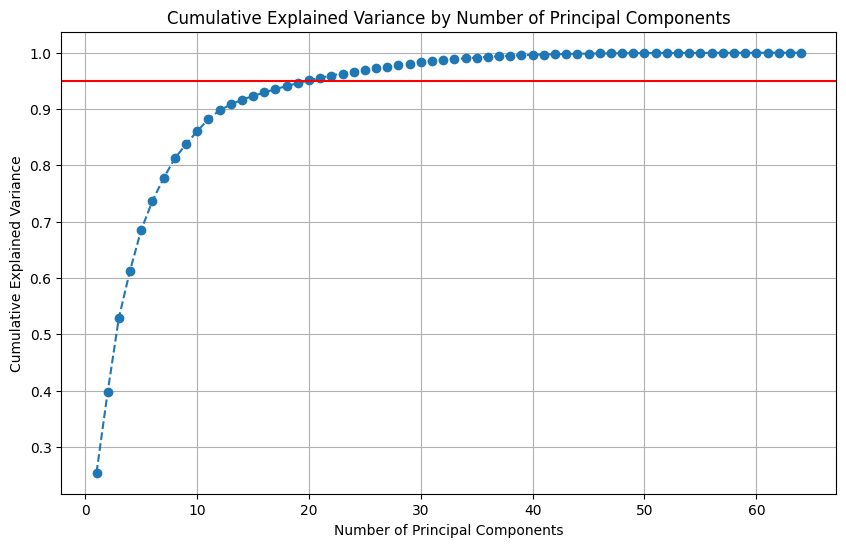

Number of components to retain 95% variance: 20
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.153611 -0.031300 -0.534141  0.309123  0.668166  0.340136  0.034852   
1  0.315785  0.267060 -0.568654  0.015265  0.436324  0.394543  0.012398   
2  0.037062  0.396768 -0.341890  0.360843  0.721247  0.308239 -0.273848   
3  0.275389  0.136078 -0.680282  0.076728  0.230117  0.329186 -0.129834   
4  0.592227  0.134994 -0.905546  0.077543  0.304110  0.460471 -0.204440   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  0.225423  0.090056  0.282426 -0.115719  0.059209  0.053139 -0.028261   
1  0.548665  0.267344  0.004540 -0.075514 -0.020472  0.035433 -0.019704   
2  0.160929 -0.022199 -0.137682 -0.000062  0.107166 -0.089339 -0.060648   
3  0.671929  0.201170  0.090668 -0.422988  0.110120  0.102628  0.117676   
4  0.953740  0.347897  0.094862 -0.311990 -0.016117  0.199755  0.065650   

       PC15      PC16      PC17      PC18      PC1

In [28]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA()


X = df_final.drop(columns='Label')
y = df_final['Label']
# Fit PCA on the scaled data
pca.fit(X)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()

# Determine the number of components to retain 95% variance
n_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f'Number of components to retain 95% variance: {n_components_95}')

# Transform the data using the selected number of principal components
pca = PCA(n_components=n_components_95)
transformed_data = pca.fit_transform(X)

# Create a DataFrame for the transformed data
columns = [f'PC{i+1}' for i in range(n_components_95)]
transformed_df = pd.DataFrame(transformed_data, columns=columns)

# Display the first few rows of the transformed dataset
print(transformed_df.head())

# Save the transformed dataset to a CSV file
transformed_df.to_csv('transformed_dataset.csv', index=False)
print('Transformed dataset saved to "transformed_dataset.csv".')


In [29]:
datafr = dataset_labeller(transformed_df, 1, targets, 0, 'Label')
datafr.to_csv('MINlambdaPCA.csv', index=False)

game interface

In [ ]:
def model_output():
  model_output = [3,4,5,6,7,8,8,9,9,9,9,1,1,1,1,1]
  with open(r"D://Documents\College\Semester-VIII\B.E. Project\MINERVA_dataset\Output\MINERVA_output.txt", "w") as file:
    file.write(str(model_output))

siamese network

In [ ]:
from scipy.spatial import distance

arr1 = df.iloc[0,:-1]
arr2 = df.iloc[24, :-1]
#print(arr1)
dist = distance.euclidean(arr1, arr2)
print(f'Euclidean distance: {dist}')
#THIS TELLS ME THIS DATASET IS A LOAD OF CRAP

Euclidean distance: 0.3171405145669065
